In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from scipy import spatial
import scipy.spatial.distance as dist
import networkx as nx
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split

In [2]:
feats = h5py.File('/cosma5/data/dp004/dc-cues1/features/halo_features_s99','r+')    

In [53]:
feats.close()

In [3]:
graphs_dir = '/cosma5/data/dp004/dc-cues1/graphs'
feats_dir = graphs_dir + '/features/'
adj_dir = graphs_dir + '/adj/'

# Generate edge list

In [4]:
positions = feats['Pos'][:]

In [5]:
tree = spatial.cKDTree(positions)

## By physical distance to neighbors

In [6]:
edges = tree.query_pairs(2000) # within 2 Mpc

In [7]:
G = nx.from_edgelist(edges)

In [8]:
print(f'There are {nx.number_connected_components(G)} disconnected components')

There are 47380 disconnected components


In [9]:
ccs = nx.connected_components(G)

In [10]:
node_component = {v:k for k,vs in enumerate(ccs) for v in vs}

In [11]:

df = pd.DataFrame(positions, columns=['x','y','z'])
df['c'] = pd.Series(node_component)
df.loc[df['c'].isna(), 'c'] = df.loc[df['c'].isna(), 'c'].isna().cumsum() + df['c'].max()


In [12]:
df['c'].value_counts().nlargest(5)

518.0    354
53.0     284
171.0    257
42.0     219
561.0    217
Name: c, dtype: int64

In [13]:
df['c'].value_counts().nsmallest(5)

67170.0    1
87467.0    1
55132.0    1
92838.0    1
87206.0    1
Name: c, dtype: int64

Text(0.5,0,'Number of neighbors')

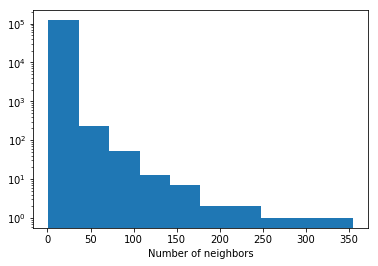

In [14]:
plt.hist(df['c'].value_counts(), log=True)
plt.xlabel('Number of neighbors')

In [15]:
# Split graph into its disconnected components

graphs = list(nx.connected_component_subgraphs(G))


In [16]:
n_nodes = []
for g in graphs:
    n_nodes.append(len(g.nodes()))

(array([4.708e+04, 2.210e+02, 5.400e+01, 1.100e+01, 7.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([  2. ,  37.2,  72.4, 107.6, 142.8, 178. , 213.2, 248.4, 283.6,
        318.8, 354. ]),
 <a list of 10 Patch objects>)

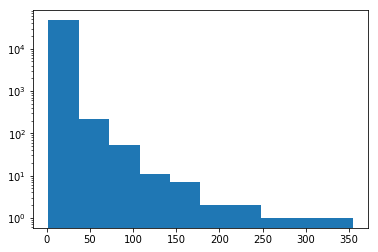

In [17]:
plt.hist(n_nodes, log=True)

In [18]:
n_nodes = np.asarray(n_nodes)

In [19]:
print(f'There are {np.sum(n_nodes < 2)} isolated nodes')

There are 0 isolated nodes


In [20]:
print(f'There are {np.sum(n_nodes == 3)} almost isolated nodes')

There are 9236 almost isolated nodes


In [21]:
print(f'There are {np.sum(n_nodes < 5)} almost isolated nodes')

There are 35525 almost isolated nodes


In [32]:
print(f'There are {np.sum(n_nodes > 150)} large graphs')

There are 11 large graphs


## Add per node features + Adjacency matrix

In [23]:
subsample_graph = [graphs[0] , graphs[1]]


In [33]:
MAX_NUMBER_NODES = 150
NUMBER_FEATURES = 9

N_nodes = np.zeros((len(graphs)))

X = np.zeros((len(graphs), MAX_NUMBER_NODES, NUMBER_FEATURES))
Y = np.zeros((len(graphs), MAX_NUMBER_NODES))
A = np.zeros((len(graphs), MAX_NUMBER_NODES, MAX_NUMBER_NODES))

In [34]:
%%time
for i, g in enumerate(graphs):
    if len(g.nodes()) < MAX_NUMBER_NODES:
        # Get node features
        X[i, :len(g.nodes()), 0] = feats['M200c'][:][g.nodes()]
        X[i, :len(g.nodes()), 1] = feats['R200c'][:][g.nodes()]
        X[i, :len(g.nodes()), 2] = feats['N_subhalos'][:][g.nodes()]
        X[i, :len(g.nodes()), 3] = feats['VelDisp'][:][g.nodes()]
        X[i, :len(g.nodes()), 4] = feats['Vmax'][:][g.nodes()]
        X[i, :len(g.nodes()), 5] = feats['Spin'][:][g.nodes()]
        X[i, :len(g.nodes()), 6] = feats['Fsub'][:][g.nodes()]
        X[i, :len(g.nodes()), 7] = feats['x_offset'][:][g.nodes()]      
        
        Y[i, :len(g.nodes())] = feats['Ngals'][:][g.nodes()]
        A[i, :len(g.nodes()),:len(g.nodes())] = nx.adjacency_matrix(g).todense()
        
        N_nodes[i] = len(g.nodes())
    

CPU times: user 2min 27s, sys: 2min 53s, total: 5min 21s
Wall time: 5min 22s


## Split into train/test/val and check same distribution of target 

In [35]:
x_train, x_test, y_train, y_test, N_nodes_train, N_nodes_test = train_test_split(X, Y, N_nodes, test_size = 0.33)
x_val, x_test, y_val, y_test, N_nodes_val, N_nodes_test = train_test_split(x_test, y_test,
                                                                                 N_nodes_test, test_size = 0.5)


In [36]:
print('N GRAPHS ')
print(f'Training : {len(x_train)}')
print(f'Test : {len(x_test)}')
print(f'Val : {len(x_val)}')
print('N NODES ')
print(f'Training : {np.sum(N_nodes_train)}')
print(f'Test : {np.sum(N_nodes_test)}')
print(f'Val : {np.sum(N_nodes_val)}')

N GRAPHS 
Training : 31744
Test : 7818
Val : 7818
N NODES 
Training : 142574.0
Test : 36184.0
Val : 34816.0


In [37]:
n_gals_test = []
m_test = []
for i in range(len(y_test)):
    m_test.append(x_test[i,:int(N_nodes_test[i]), 0])
    n_gals_test.append(y_test[i, :int(N_nodes_test[i])])
    
n_gals_test = [item for sublist in n_gals_test for item in sublist]
m_test = [item for sublist in m_test for item in sublist]


In [38]:
n_gals_val = []
m_val = []
for i in range(len(y_val)):
    n_gals_val.append(y_val[i, :int(N_nodes_val[i])])
    m_val.append(x_val[i,:int(N_nodes_val[i]), 0])

n_gals_val = [item for sublist in n_gals_val for item in sublist]
m_val = [item for sublist in m_val for item in sublist]


In [39]:
n_gals_train = []
m_train = []

for i in range(len(y_val)):
    n_gals_train.append(y_train[i, :int(N_nodes_train[i])])
    m_train.append(x_train[i,:int(N_nodes_train[i]), 0])
    
n_gals_train = [item for sublist in n_gals_train for item in sublist]
m_train = [item for sublist in m_train for item in sublist]


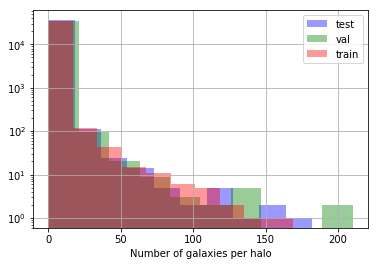

In [42]:
plt.hist(n_gals_test, log=True, color='blue', alpha = 0.4, label = 'test')
plt.hist(n_gals_val, log=True, color='green', alpha = 0.4, label = 'val')
plt.hist(n_gals_train, log=True, color='red', alpha = 0.4, label = 'train')
plt.legend()
plt.xlabel('Number of galaxies per halo')
plt.grid()

In [44]:
n_gals_test = np.asarray(n_gals_test)
n_gals_val = np.asarray(n_gals_val)
n_gals_train = np.asarray(n_gals_train)

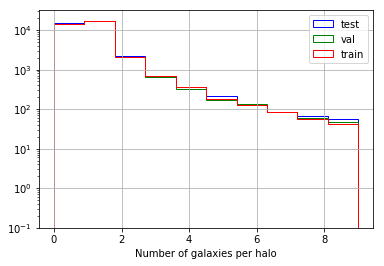

In [51]:
plt.hist(n_gals_test[n_gals_test < 10], log=True, color='blue', label = 'test', histtype='step')
plt.hist(n_gals_val[n_gals_val < 10], log=True, color='green',  label = 'val', histtype='step')
plt.hist(n_gals_train[n_gals_train < 10], log=True, color='red',  label = 'train', histtype='step')
plt.legend()
plt.xlabel('Number of galaxies per halo')
plt.grid()

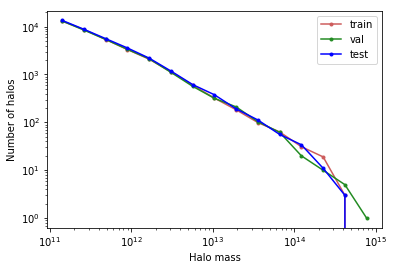

In [52]:

nbins= 15
bins = np.logspace(11, 15, nbins+1)

mass_func, edges = np.histogram(m_train, bins=bins)
plt.loglog((edges[1:]+edges[:-1])/2.,
           mass_func,color='indianred', marker='o',markersize=3,
           label='train')

mass_func, edges = np.histogram(m_val, bins=bins)

plt.loglog((edges[1:]+edges[:-1])/2.,
           mass_func,color='forestgreen', marker='o',markersize=3,
           label='val')

mass_func, edges = np.histogram(m_test, bins=bins)

plt.loglog((edges[1:]+edges[:-1])/2.,
           mass_func,color='blue', marker='o',markersize=3,
           label='test')
plt.ylabel('Number of halos')
plt.xlabel('Halo mass')
plt.legend()